# Imaginative Networks
## A Social Network Analysis of Dedications in Early Modern Printed Books

John R. Ladd | 17 February 2020

In [15]:
# Begin by importing necessary libraries
import networkx as nx
from networkx.readwrite import json_graph
from networkx.algorithms import bipartite, community
import json
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pyvis.network import Network
from random import sample

plt.style.use('ggplot') # Automatically give all charts nice styling

# Two custom functions for splitting the network by time

def filter_by_year(year, B):
    """
    A function for creating subgraphs for each year
    """
    nodes = []
    for n in B.nodes(data=True):
        try:
            if int(n[1]['date']) == year:
                nodes.append(n[0])
                nodes.extend(B.neighbors(n[0]))
        except (KeyError, ValueError, TypeError) as e:
            pass
    SB = B.subgraph(nodes)
    return SB

def filter_by_range(start_year,end_year, B):
    """
    Similar to the year filter (above), filter the
    full graph by a range of years and create a subgraph.
    """
    nodes = []
    for n in B.nodes(data=True):
        try:
            if int(n[1]['date']) in range(start_year, end_year):
                nodes.append(n[0])
                nodes.extend(B.neighbors(n[0]))
        except (KeyError, ValueError, TypeError) as e:
            pass
    SB = B.subgraph(nodes)
    return SB

In [16]:
B = nx.read_gpickle('../data/test_joined0826.pkl')
print(nx.info(B))
for n,d in B.nodes(data=True):
    try:
        if d['date'] == None:
            B.nodes[n]['date'] = 'No date listed'
    except KeyError:
        pass
    if d['bipartite'] == 'person':
        B.nodes[n]['displayname'] = B.nodes[n]['display_name']
        del B.nodes[n]['display_name']
# nx.write_gml(B, "../data/test_joined0826.gml")
names = {n for n,d in B.nodes(data=True) if d['bipartite'] == 'person'}
print("Names:", len(names))

print("Texts:", len({n for n,d in B.nodes(data=True) if d['bipartite'] == 'text'}))

print("Density:", bipartite.density(B, names))

Name: 
Type: Graph
Number of nodes: 54679
Number of edges: 113862
Average degree:   4.1647
Names: 42687
Texts: 11992
Density: 0.0002224290741113468


In [17]:
# Basic Data on Network
# print(list(B.edges(data=True))[:100])
def get_data(B):
    texts = len({n for n,d in B.nodes(data=True) if d['bipartite'] == 'text'})
    dedicators = []
    dedicatees = []
    others = []
    for s,t,d in B.edges(data=True):
        if d['isauthor'] == 'true':
            dedicators.append(s)
        elif 'head' in d['container']:
            dedicatees.append(s)
        else:
            others.append(s)
    return {'# texts': texts, '# dedicators': len(set(dedicators)), '# dedicatees': len(set(dedicatees)), '# others': len(set(others))}

decade_data = {}
for x in range(1470,1700,10):
#     print(x, x+5)
    SB = filter_by_range(x, x+10, B)
    decade_data[f"{x}-{x+10}"] = get_data(SB)
# get_data(SB)
df = pd.DataFrame(decade_data)
df = df.T
df
# df.to_csv("../data/data_summary.csv")

,# dedicatees,# dedicators,# others,# texts
1470-1480,0,0,2,1
1480-1490,3,0,12,1
1490-1500,0,0,13,1
1500-1510,0,0,0,0
1510-1520,0,0,0,0
1520-1530,11,2,13,7
1530-1540,26,3,100,22
1540-1550,126,17,335,80
1550-1560,154,29,403,90
1560-1570,211,35,698,140


## Subgraph for 1660

In [53]:
# As a test, create a subgraph for 1660
SB = filter_by_year(1660, B)
print("Full Network for 1660")
# nx.write_edgelist(SB, "1660_full.edgelist", data=False)
# nx.write_gml(SB, "1660_full.gml")

names = {n for n,d in SB.nodes(data=True) if d['bipartite'] == 'person'}

degree_texts, degree_names = bipartite.degrees(SB, names)
degree_names_sorted = sorted(degree_names, key=lambda n:n[1], reverse=True)
degree_texts_sorted = sorted(degree_texts, key=lambda n:n[1], reverse=True)
strength_texts, strength_names = bipartite.degrees(SB, names, weight='weight')
# print(strength)
degree_centrality = bipartite.degree_centrality(SB, names)
print("\nTop Ten People by Degree:\n")
for n,degree in degree_names_sorted[:20]:
    print(f"{n}|{SB.nodes[n]['displayname']}|{degree}|{strength_names[n]}|{round(degree_centrality[n],3)}")
    
# nx.write_gml(SB, "../data/test_1660.gml")
subnodes = [p[0] for p in degree_names_sorted[:25]]
neighbors = list(set(list(sum([list(SB.neighbors(s)) for s in subnodes], []))))
subnodes.extend(neighbors)
# print(subnodes)
# SB = SB.subgraph(subnodes)
print(nx.info(SB))
# names = {n for n,d in SB.nodes(data=True) if d['bipartite'] == 'person'}
texts = {n for n,d in SB.nodes(data=True) if d['bipartite'] == 'text'}
print("Names:", len(names))

print("Texts:", len(texts))
          
print("Density:", bipartite.density(SB, names))
# viz = hf.convert_nx(SB)
# viz.show_buttons()
# viz.show("year_graph.html")

Full Network for 1660

Top Ten People by Degree:

126033|God|144|712|0.64
104495|Jesus Christ|65|225|0.289
111734|David|26|57|0.116
101427|Charles Ii|20|21|0.089
108610|St Paul|19|22|0.084
133188|Moses|18|27|0.08
110832|St John|16|17|0.071
105361|King James|15|19|0.067
140498|King Charles|14|15|0.062
141874|Solomon|14|23|0.062
106647|Satan|13|16|0.058
115297|King Henry|12|13|0.053
112509|St Thomas|8|8|0.036
135589|Caesar|7|12|0.031
125390|Job|7|10|0.031
126796|Queen Elizabeth|7|7|0.031
106425|General Monck|7|7|0.031
110709|Abraham|6|8|0.027
135309|William Prynne|6|7|0.027
111645|St Peter|6|6|0.027
Name: 
Type: Graph
Number of nodes: 1496
Number of edges: 1972
Average degree:   2.6364
Names: 1271
Texts: 225
Density: 0.006895707666754087


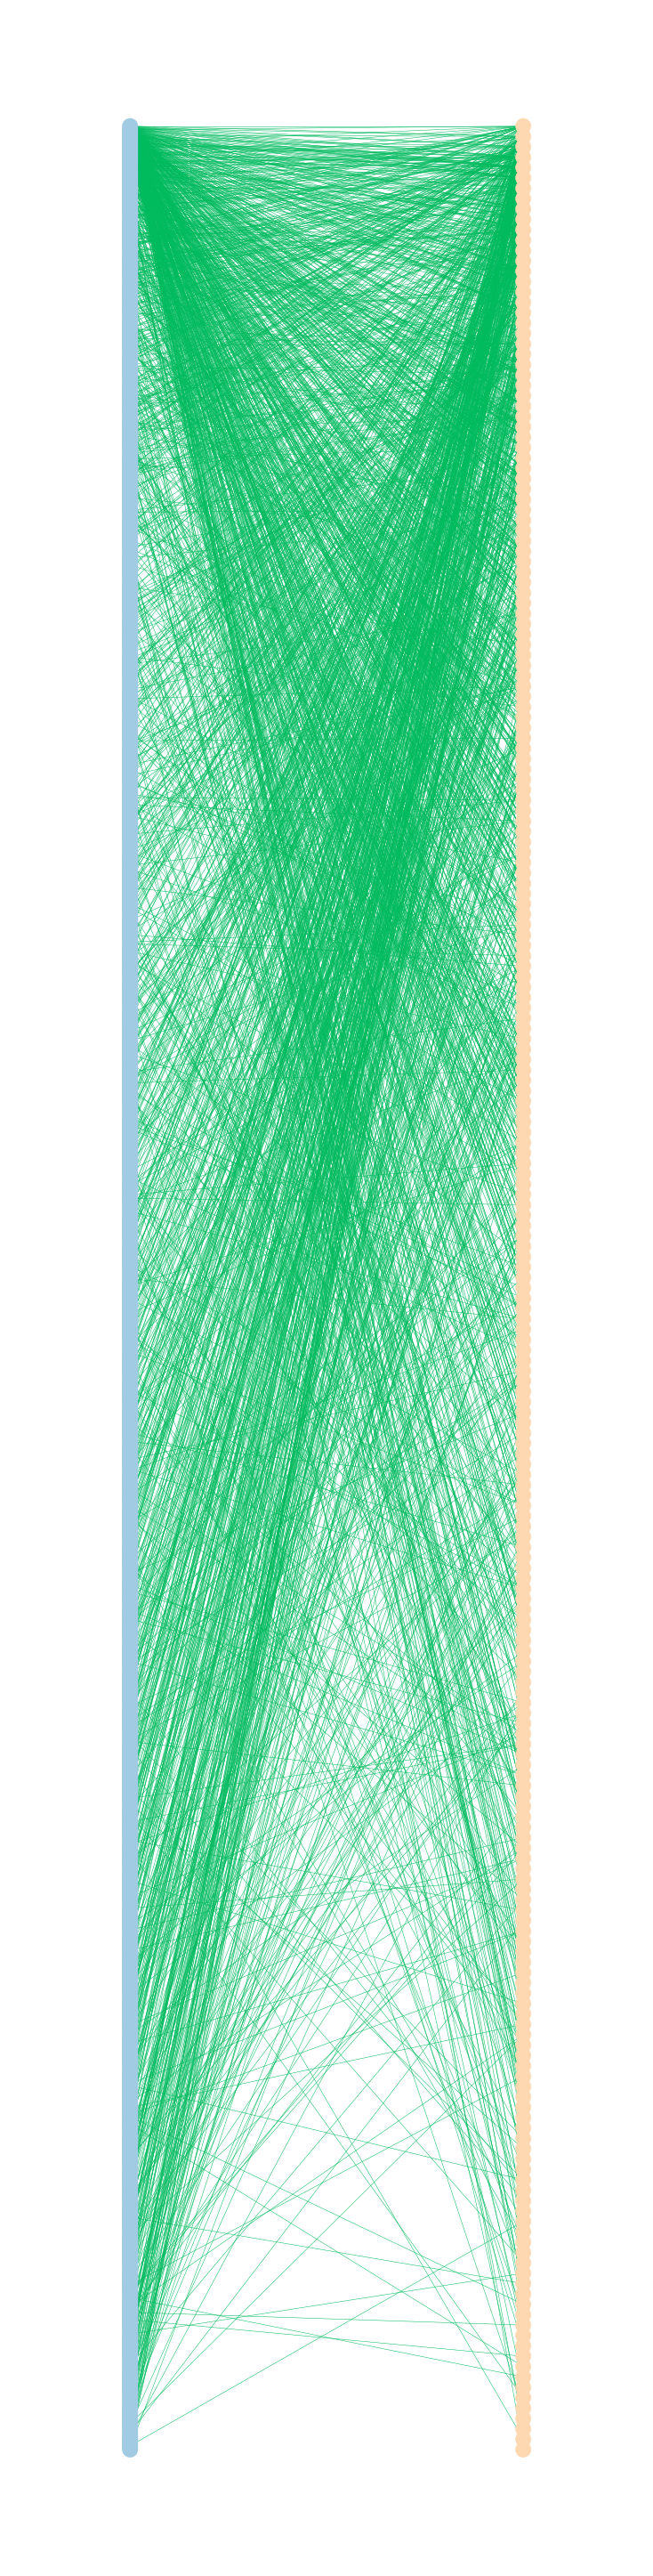

In [6]:
plt.figure(figsize=(10,40))
pos = nx.bipartite_layout(SB, names, aspect_ratio=1/40)
ordered_pos = {}
degree_names_sorted.reverse()
degree_texts_sorted.reverse()
# node_size = [SB.degree(n)*300 for n,d in people_by_degree]
# node_size.extend([SB.degree(n) for n,d in texts_by_degree])
# print(node_size)
node_color = ["#A0CBE2" if d['bipartite'] == 'person' else "#FED8B1" for n,d in SB.nodes(data=True)]
labels = {n:d['displayname'] if d['bipartite'] == 'person' else n for n,d in SB.nodes(data=True)}
for i,t in enumerate(pos.items()):
    if i < len(degree_names_sorted):
#         print(people_by_degree[i])
        ordered_pos[degree_names_sorted[i][0]] = t[1]
    else:
        ordered_pos[degree_texts_sorted[i-len(degree_names_sorted)][0]] = t[1]
nx.draw(SB, pos=ordered_pos, node_color=node_color, node_size=300, edge_color='#00bb5e',width=.5, with_labels=False, labels=labels, horizontalalignment='left')
plt.show()

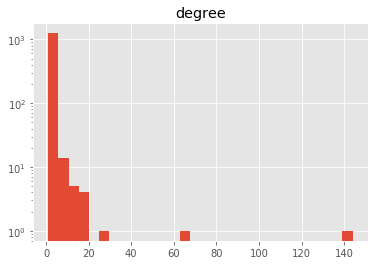

In [7]:
dc_names = {k:v for k,v in degree_centrality.items() if k in names}
degree_table = pd.DataFrame([dict(degree_names), dict(strength_names), dc_names], index=['degree','strength', 'degree centrality'])
degree_table.T.hist(column="degree", bins=30)
plt.yscale('log')
plt.show()

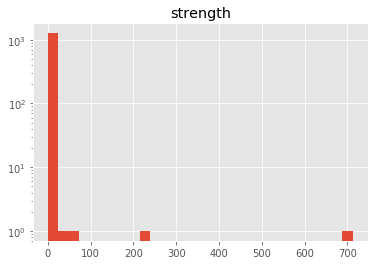

In [41]:
degree_table.T.hist(column="strength", bins=30)
plt.yscale('log')
plt.show()

In [44]:
for n,d in degree_names:
    print(n, SB.nodes[n]['displayname'], d)

114688 St Gregory 1
102403 Richard Matthew 1
131078 Patient 1
139272 Gusman 1
114700 Captain Gilbert Crouch 1
131087 Burleigh 1
139282 Swainswick 1
122902 Salus Populi 1
102422 Josephus Crabb 1
131097 Isabella 1
135194 Antipoedo 1
122917 William Earl Of Glencairn Lord Of Kilmawers 1
135207 Corah 2
102440 Josias 1
114734 Henry Duke Of Gloucester 1
110640 Humphredo 1
139315 Dissimularion 1
131123 Thomas Warmstry 1
110646 Father Of Glorious 2
118841 Mr Crofton 1
127036 Cyprian 2
131134 Archbishop Of Spalleto 1
127041 Cornelius Agrippa 1
118851 Iii 1
127049 Achaia 1
135252 William Paston 2
114773 Episcopomastix 1
106581 Orb Andrew 1
102497 Josiah 3
106594 Dr Whichcote 1
131171 Herod 4
102498 Maximinus 1
118883 Abiram 1
106598 Giove 1
118882 Gynesio 1
131176 Shimei 3
122986 Volesos Brutumque 1
131181 Religi●…N 1
139373 Rabelais 1
102514 Of Ratcliff 1
139381 Literarum 1
114806 John Brinsley 1
110709 Abraham 6
131199 David Lloyd 1
102529 Robert Cotton 1
135299 Symiones 1
123016 John Pearson 1

108870 Aeneas 2
104776 Toby 1
125267 Bold 1
137555 Nehemiah 1
121173 Elijah 1
141657 Thesaurer 1
112990 Boscobel 1
100704 Epicurus 1
117090 Cardinal Bellarm 1
112999 Father Will 1
104810 George Hammon 1
133483 Kid 1
137582 Samson 3
113007 Bellarmin 1
137588 Earl Marischall 1
133493 John Earl Of Lauder Daill 1
137592 Te●Iti● 1
113019 Overdo Them 2
137597 Romano Pontifice 1
141694 John Bewick 1
117124 Theseus 2
108936 Celsus 1
141705 J Gauden 3
137609 O●… 1
137614 Chro 1
141714 H Hammond 1
113043 A Hulsius 1
117141 Ri Henchman 1
125338 Bevis Of 1
104860 Cato 1
121249 Jehovah 2
117155 Salmasius 1
108966 Benjamin 1
104875 Cerda 1
117168 Bishop Andrews Bishop Morton 1
129461 Mr Moor 1
141750 Hebron 1
108982 Wonarinus 1
121270 Pelagius 1
125386 Go●S 1
109003 Featley 1
141774 Celsus Performance 1
125390 Job 7
117201 Pseudoapostoli 1
117204 Zachariah 1
129492 John Salusbury 1
129494 Edward Lord Hyde 1
141787 Samuel Cradock 1
137694 Edmond Warcupp 1
141791 Endor 1
109028 Ambrose 2
121324 Jeduth

In [50]:
# Density comparison
aseq = [d for n,d in degree_names]
x = 0
densities = []
while x < 10:
    R = bipartite.preferential_attachment_graph(aseq, len(texts)/len(names))
    top = {n for n,d in R.nodes(data=True) if d['bipartite'] == 0}
    print(nx.info(R))
    density = bipartite.density(R,top)
    print("Density", density)
    densities.append(density)
    x += 1
    
print("Average Density", sum(densities)/len(densities))

Name: bipartite_preferential_attachment_model
Type: MultiGraph
Number of nodes: 1599
Number of edges: 1972
Average degree:   2.4665
Density 0.004730287271401431
Name: bipartite_preferential_attachment_model
Type: MultiGraph
Number of nodes: 1631
Number of edges: 1972
Average degree:   2.4181
Density 0.004309817291721305
Name: bipartite_preferential_attachment_model
Type: MultiGraph
Number of nodes: 1621
Number of edges: 1972
Average degree:   2.4331
Density 0.004432954928627627
Name: bipartite_preferential_attachment_model
Type: MultiGraph
Number of nodes: 1627
Number of edges: 1972
Average degree:   2.4241
Density 0.004358242205111431
Name: bipartite_preferential_attachment_model
Type: MultiGraph
Number of nodes: 1599
Number of edges: 1972
Average degree:   2.4665
Density 0.004730287271401431
Name: bipartite_preferential_attachment_model
Type: MultiGraph
Number of nodes: 1604
Number of edges: 1972
Average degree:   2.4589
Density 0.004659261936996005
Name: bipartite_preferential_attac

In [67]:
# Strength/Degree comparisons
print("Strength Over Degree")
strength_over_degree = {n:strength_names[n]/degree_names[n] for n,d in SB.nodes(data=True) if d['bipartite'] == 'person'}
strength_over_degree = sorted(strength_over_degree.items(), key=lambda n:n[1], reverse=True)
for n, d in strength_over_degree[:20]:
    print(f"{n}|{SB.nodes[n]['displayname']}|{degree_names[n]}|{strength_names[n]}|{round(d,3)}")
    
# print("\nDegree Over Strength")
# degree_over_strength = {n:degree_names[n]/strength_names[n] for n,d in SB.nodes(data=True) if d['bipartite'] == 'person'}
# degree_over_strength = sorted(degree_over_strength.items(), key=lambda n:n[1], reverse=True)
# for n, d in degree_over_strength[:10]:
#     print(f"{n}|{SB.nodes[n]['displayname']}|{degree_names[n]}|{strength_names[n]}|{d}")   

Strength Over Degree
108936|Celsus|1|10|10.0
119927|Juvenal|1|6|6.0
113792|Jeroboam|3|18|6.0
107255|Jansenius|1|5|5.0
104296|Ephraim|1|5|5.0
128960|Therammenes|1|5|5.0
105583|Brounrig|1|5|5.0
126033|God|144|712|4.944
117031|Critias|1|4|4.0
109028|Ambrose|2|8|4.0
117768|Jehoshaphat|1|4|4.0
127113|John Heydon|1|4|4.0
119399|Eve|1|4|4.0
104495|Jesus Christ|65|225|3.462
123518|Thomas White|1|3|3.0
116693|Henry Jeanes|1|3|3.0
117265|Orbis|1|3|3.0
101079|Avicen|1|3|3.0
135617|Suarez|2|6|3.0
111052|Camerwell|1|3|3.0


In [70]:
# Betweenness/Degree Comparison
betweenness = bipartite.betweenness_centrality(SB, names)

betweenness_degree = {n:betweenness[n]/degree_centrality[n] for n,d in SB.nodes(data=True) if d['bipartite'] == 'person'}
betweenness_degree = sorted(betweenness_degree.items(), key=lambda n:n[1], reverse=True)
for n, d in betweenness_degree[:20]:
    print(f"{n}|{SB.nodes[n]['displayname']}|{round(betweenness[n],3)}|{round(degree_centrality[n],3)}|{round(d,3)}")

132630|Maecenas|0.018|0.013|1.366
104552|Vespasian|0.009|0.009|0.96
126033|God|0.553|0.64|0.864
137792|Thomas Bodley|0.006|0.009|0.687
113701|John Earnly|0.006|0.009|0.687
132460|Plato|0.008|0.013|0.622
133382|Hippocrates|0.008|0.013|0.616
134423|St James|0.01|0.018|0.578
112509|St Thomas|0.02|0.036|0.558
112708|Galen|0.005|0.009|0.547
136855|Mercury|0.007|0.013|0.52
139182|Plutarch|0.007|0.013|0.494
112174|Alexander|0.013|0.027|0.492
114830|John Calvin|0.004|0.009|0.428
137206|Nilus|0.004|0.009|0.413
137942|Urania|0.004|0.009|0.413
105886|Democracy|0.004|0.009|0.413
104495|Jesus Christ|0.115|0.289|0.398
134567|Phaeton|0.005|0.013|0.357
108864|Mars|0.004|0.013|0.329


## 1660 Subgraph -- Header/Signed

In [45]:
# for s,t,d in SB.edges(data=True):
#     print(s,t,d)
edgeset = [(s,t) for s,t,d in SB.edges(data=True) if "head" in d['container'] or "signed" in d['container']]
SB_header_signed = SB.edge_subgraph(edgeset)
print(nx.info(SB_header_signed))

hs_names = {n for n,d in SB_header_signed.nodes(data=True) if d['bipartite'] == 'person'}
hs_texts = {n for n,d in SB_header_signed.nodes(data=True) if d['bipartite'] == 'text'}

print("Names:", len(hs_names))

print("Texts:", len(hs_texts))
          
print("Density:", bipartite.density(SB_header_signed, hs_names))

Name: 
Type: Graph
Number of nodes: 647
Number of edges: 553
Average degree:   1.7094
Names: 444
Texts: 203
Density: 0.006135445790618204


In [46]:
degree_texts, degree_names = bipartite.degrees(SB_header_signed, hs_names)
degree_names_sorted = sorted(degree_names, key=lambda n:n[1], reverse=True)
degree_texts_sorted = sorted(degree_texts, key=lambda n:n[1], reverse=True)
strength_texts, strength_names = bipartite.degrees(SB_header_signed, hs_names, weight='weight')
# print(strength)
degree_centrality = bipartite.degree_centrality(SB_header_signed, hs_names)
print("\nTop Ten People by Degree:\n")
for n,degree in degree_names_sorted[:20]:
    print(f"{n}|{SB_header_signed.nodes[n]['displayname']}|{degree}|{strength_names[n]}|{round(degree_centrality[n],3)}")


Top Ten People by Degree:

104495|Jesus Christ|19|107|0.094
101427|Charles Ii|17|18|0.084
126033|God|11|85|0.054
140498|King Charles|6|6|0.03
112509|St Thomas|6|6|0.03
135309|William Prynne|5|6|0.025
115297|King Henry|5|5|0.025
110832|St John|4|4|0.02
101782|Edward Reynolds|4|4|0.02
123321|Thomas Aleyn|4|4|0.02
118957|John Robinson|3|3|0.015
106863|William Towers|3|3|0.015
141705|J Gauden|3|3|0.015
135637|Thomas Hall|3|3|0.015
125505|Richard Baxter|3|3|0.015
135861|Richard Brown|3|3|0.015
105361|King James|3|3|0.015
106425|General Monck|3|3|0.015
113701|John Earnly|2|2|0.01
135252|William Paston|2|2|0.01


In [48]:
# Density comparison
aseq = [d for n,d in degree_names]
x = 0
densities = []
while x < 10:
    R = bipartite.preferential_attachment_graph(aseq, len(hs_texts)/len(hs_names))
    top = {n for n,d in R.nodes(data=True) if d['bipartite'] == 0}
    print(nx.info(R))
    density = bipartite.density(R,top)
    print("Density", density)
    densities.append(density)
    x += 1
    
print("Average Density", sum(densities)/len(densities))

Name: bipartite_preferential_attachment_model
Type: MultiGraph
Number of nodes: 701
Number of edges: 553
Average degree:   1.5777
Density 0.004846285974690644
Name: bipartite_preferential_attachment_model
Type: MultiGraph
Number of nodes: 671
Number of edges: 553
Average degree:   1.6483
Density 0.005486764297336985
Name: bipartite_preferential_attachment_model
Type: MultiGraph
Number of nodes: 715
Number of edges: 553
Average degree:   1.5469
Density 0.004595924337621755
Name: bipartite_preferential_attachment_model
Type: MultiGraph
Number of nodes: 708
Number of edges: 553
Average degree:   1.5621
Density 0.004717785967785968
Name: bipartite_preferential_attachment_model
Type: MultiGraph
Number of nodes: 684
Number of edges: 553
Average degree:   1.6170
Density 0.005189564564564564
Name: bipartite_preferential_attachment_model
Type: MultiGraph
Number of nodes: 708
Number of edges: 553
Average degree:   1.5621
Density 0.004717785967785968
Name: bipartite_preferential_attachment_model


## Nodes in full graph over time

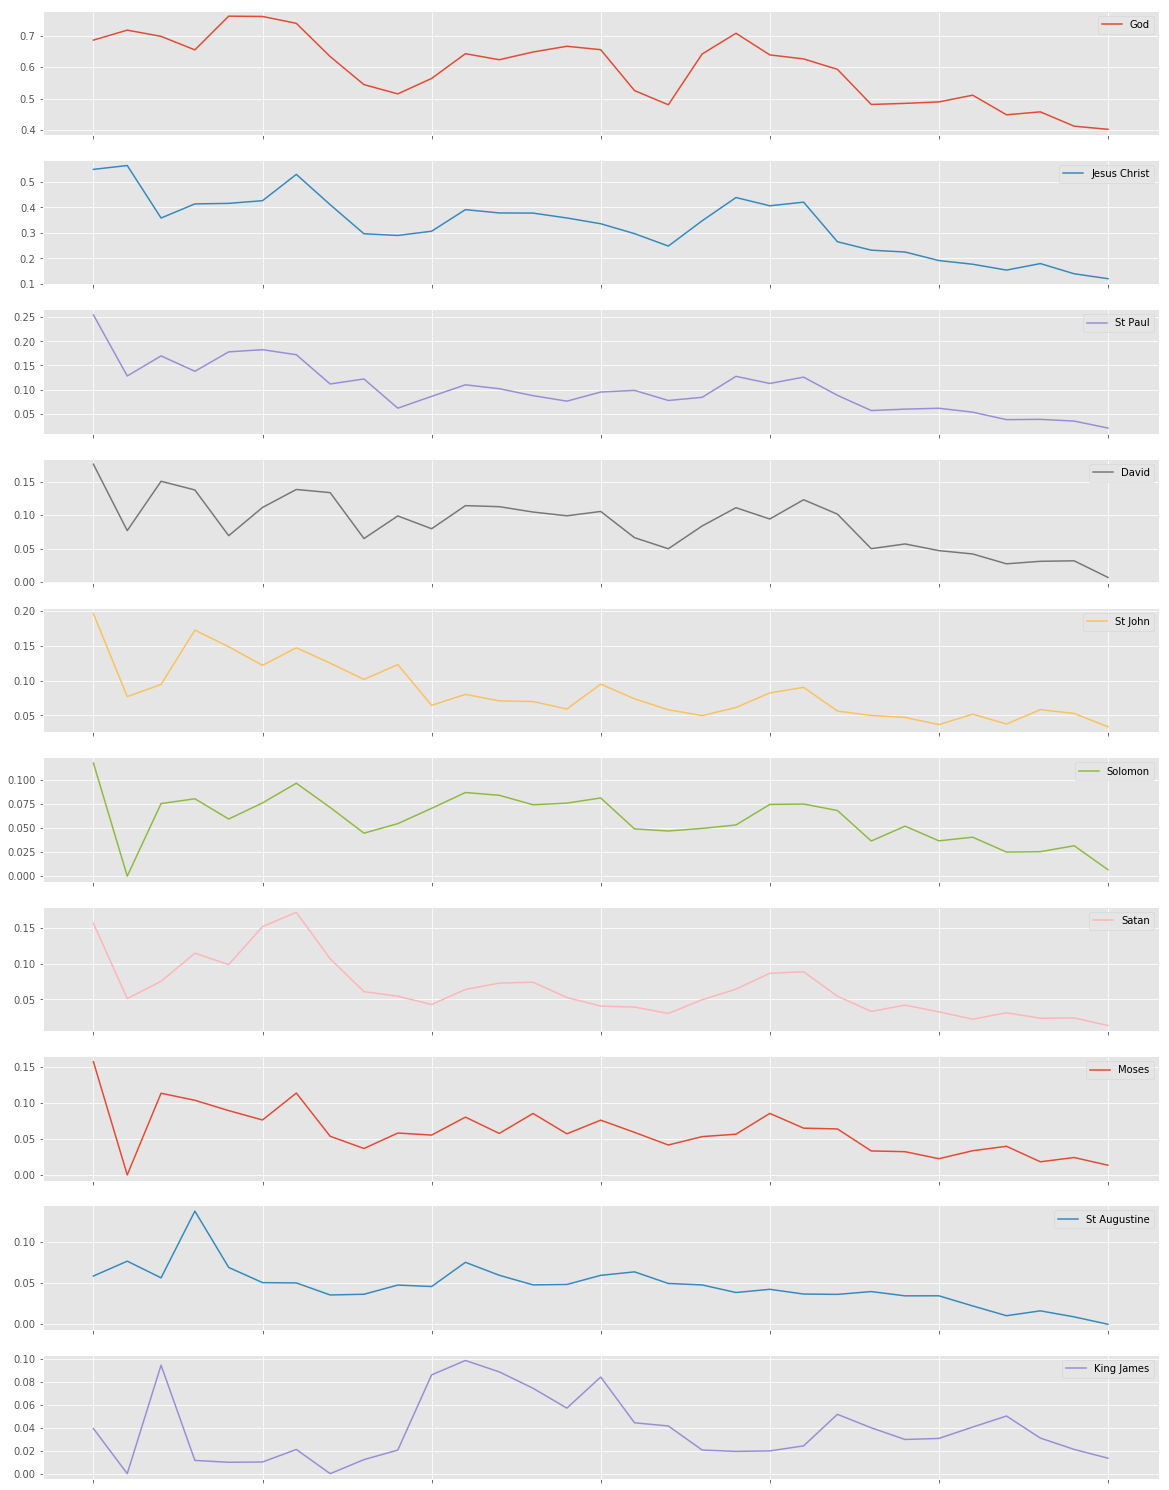

In [30]:
# The maximum range I could analyze was 1531-1700
# Create a dictionary of subgraphs for that range
graphs_by_year = {f"{x}-{x+5}":filter_by_range(x,x+5,B) for x in range(1550,1701,5)}

all_names = {n for n,d in B.nodes(data=True) if d['bipartite'] == 'person'}
degree_centrality_all = bipartite.degree_centrality(B, all_names)
# To analyze the people with the most connections, I need a sorted list of the highest degree-people.
all_degree_names = sorted(all_names, key=lambda n:degree_centrality_all[n], reverse=True)
top_people = all_degree_names[:10]

# To get the graph for the "projected degree" over time, I needed to
# project every subgraph and record the degreen
dc_by_year = {}

for year,G in graphs_by_year.items():
    sub_people_nodes = {n for n, d in G.nodes(data=True) if d['bipartite'] == 'person'}
#     print(year,G.nodes())
    dc = bipartite.degree_centrality(G,sub_people_nodes)
    dc_by_year[year] = dc
    
# print(dc_by_year)
# Make a dataframe for easy graphing
df = pd.DataFrame(dc_by_year).fillna(0)
df_top = df.filter(top_people, axis=0)
df_top = df_top.rename({n:B.nodes[n]['displayname'] for n in top_people})
# df = hf.create_dataframe(dc_by_year,top_people,B)
tf = df_top.T

# Create subplots for each person
ax = tf.plot(subplots=True, figsize=(20,30))

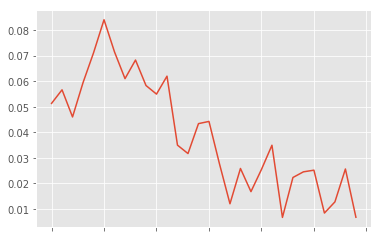

In [31]:
# Time series for Elizabeth

eliz_id = 126796
eliz_data = {}
for k,v in dc_by_year.items():
    try:
        eliz_data[k] = v[eliz_id]
    except KeyError:
        pass
    
eliz = pd.Series(eliz_data)
eliz.plot()

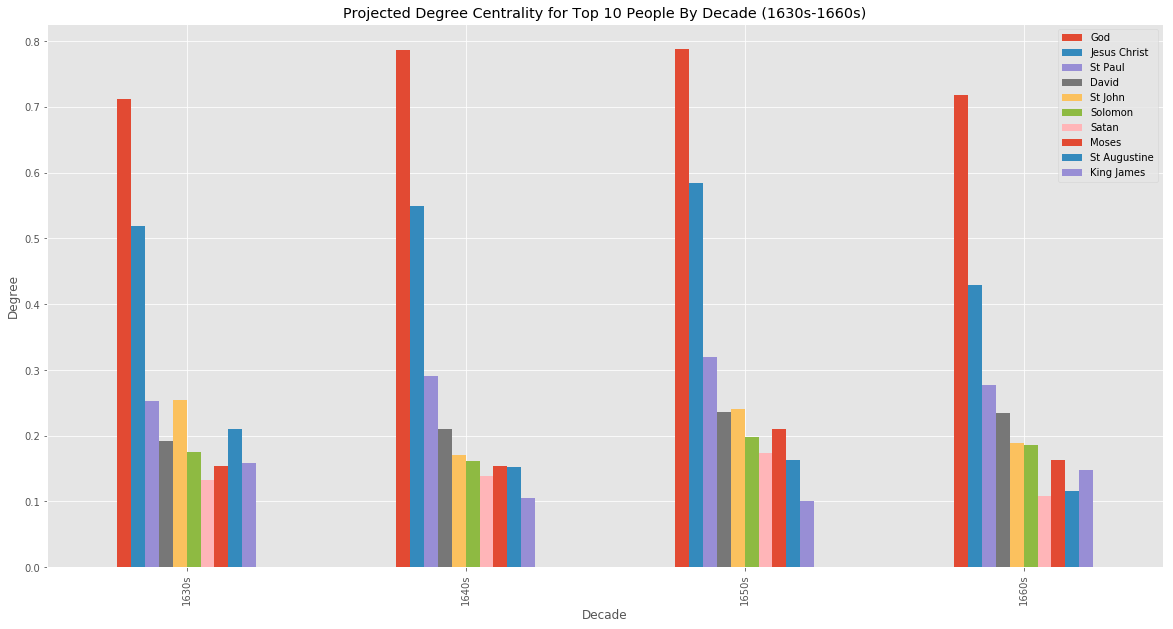

In [23]:
# Create a subgraph for decades around the Civil War/Interregnum period (and immediately before and after)
decade_graphs = {'1630s':hf.filter_by_range(1630,1639,B),
                 '1640s':hf.filter_by_range(1639,1649,B), 
                 '1650s':hf.filter_by_range(1650,1659,B), 
                 '1660s':hf.filter_by_range(1660,1669,B)
                }

# Find centralities by decade
decade_centralities = {}
    
for year,G in decade_graphs.items():
    sub_people_nodes = {n for n, d in G.nodes(data=True) if type(n) == int}
    projected_G = bipartite.projected_graph(G, sub_people_nodes)
    decade_centralities[year] = nx.degree_centrality(projected_G)
        
# Create a dataframe for the top ten people (but eliminate Christ and St. Paul for readability)
dbdf = hf.create_dataframe(decade_centralities,top_people,B)
tdbdf = dbdf.T
# Plot as a bar graph instead of a line graph
ax = tdbdf.plot(kind='bar', figsize=(20,10), title="Projected Degree Centrality for Top 10 People By Decade (1630s-1660s)")
ax.set_xlabel('Decade')
ax.set_ylabel('Degree')
plt.legend()#loc='center left', bbox_to_anchor=(1.0, 0.5))  


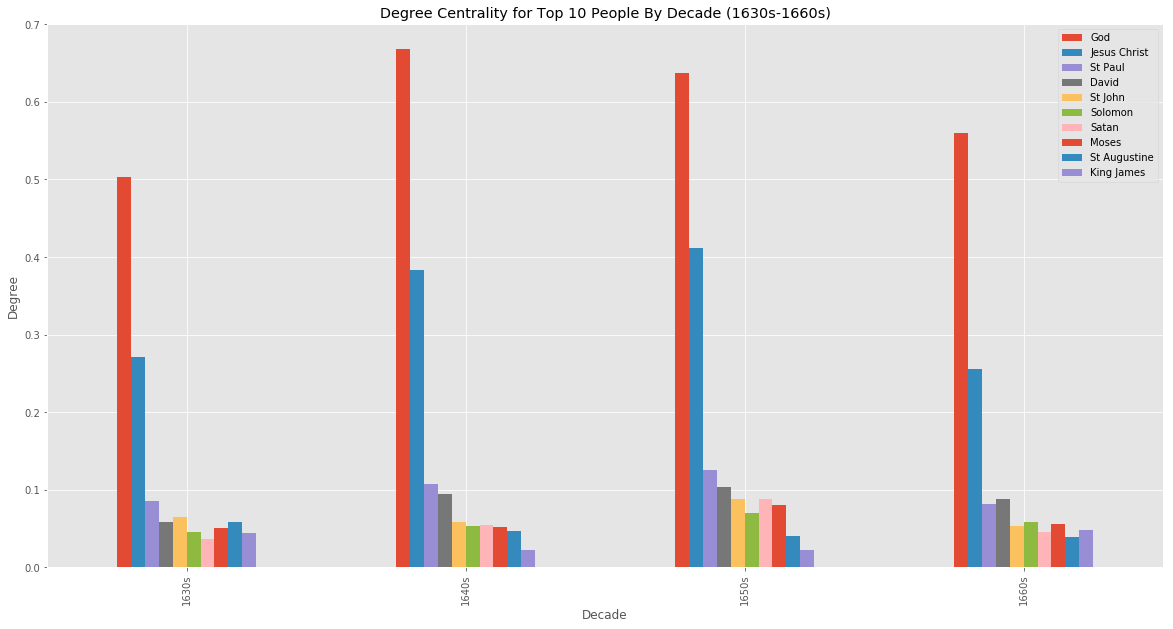

In [24]:
# Create a subgraph for decades around the Civil War/Interregnum period (and immediately before and after)
decade_graphs = {'1630s':hf.filter_by_range(1630,1639,B),
                 '1640s':hf.filter_by_range(1639,1649,B), 
                 '1650s':hf.filter_by_range(1650,1659,B), 
                 '1660s':hf.filter_by_range(1660,1669,B)
                }

# Find centralities by decade
decade_centralities = {year:bipartite.degree_centrality(G, {n for n, d in G.nodes(data=True) if type(n) == int}) for year,G in decade_graphs.items()}
        
# Create a dataframe for the top ten people (but eliminate Christ and St. Paul for readability)
dbdf = hf.create_dataframe(decade_centralities,top_people, B)
tdbdf = dbdf.T
# Plot as a bar graph instead of a line graph
ax = tdbdf.plot(kind='bar', figsize=(20,10), title="Degree Centrality for Top 10 People By Decade (1630s-1660s)")
ax.set_xlabel('Decade')
ax.set_ylabel('Degree')
plt.legend()#loc='center left', bbox_to_anchor=(1.0, 0.5))  

By betweenness centrality:

In [13]:
# Need the itemgetter module for easier sorting
from operator import itemgetter
import pickle as pkl

# Import all the betweenness measures from a file I created earlier
with open('all_betweenness.pkl', 'rb') as newf:
    all_betweenness = pkl.load(newf)

people_nodes = {n for n, d in B.nodes(data=True) if d['bipartite']==1}
# Get betweenness for just the people nodes and sort them
all_betweenness_people = {k:v for k,v in all_betweenness.items() if k in people_nodes}
all_betweenness_sorted = sorted(all_betweenness_people.items(), key=itemgetter(1), reverse=True)

# Keep track of the ids and get the top ten nodes by betweenness
abs_ids = [a[0] for a in all_betweenness_sorted[:10]]
top_ten_betweenness = []
for a in abs_ids:
    for n in B.nodes(data=True):
        if n[0] == a:
            top_ten_betweenness.append(n)

with open('decade_betweenness.pkl', 'rb') as newf:
    decade_betweenness = pkl.load(newf)
    
# Create a datagrame and graph these results (eliminate Christ for readability)
ddf = hf.create_dataframe(decade_betweenness,top_ten_betweenness[1:])
tddf = ddf.T
ax = tddf.plot(kind='bar', figsize=(20,10), title="Betweenness Centrality for Top 10 People By Decade (1630s-1660s)")
ax.set_xlabel('Decade')
ax.set_ylabel('Betweenness Centrality')
plt.legend()#loc='lower center')#, bbox_to_anchor=(0.5, 1.0))

FileNotFoundError: [Errno 2] No such file or directory: 'all_betweenness.pkl'